# Iris Flower Dataset

This document presents intepretation method for the Iris Flower Dataset (see https://en.wikipedia.org/wiki/Iris_flower_data_set). The interpretation is produced using LIME and our aproches M-LIME.



In [2]:
import sys
sys.path.append('..')

import numpy as np
from sklearn import datasets
import sklearn.ensemble
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt

import lime.lime_tabular
from m_lime.explainers.explainer import Explainer
from m_lime.generators.kde_gen import KDEGen
from m_lime.generators.kdepca_gen import KDEPCAGen
from m_lime.explainers.visualizations.plot_importance import ExplainGraph

# Load Data 

In [3]:
data = datasets.load_iris()
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data.data, data.target, train_size=0.80)

# Training a RF Model

In [4]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.fit(x_train, y_train)
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
y_all_pred = rf.predict(data.data)

In [5]:
print('Acurancy_score: ', metrics.accuracy_score(y_test, y_test_pred))
print('Random Forest Mean Square Error: ', np.mean((y_test_pred - y_test) ** 2))
print('MSError when predicting the mean: ', np.mean((y_train.mean() - y_test) ** 2))

Acurancy_score:  0.9666666666666667
Random Forest Mean Square Error:  0.03333333333333333
MSError when predicting the mean:  0.7006249999999999


# Interpretation and Explanation

In [6]:
from m_lime.explainers.visualizations.visualization import GridPlot

In [7]:
i = 3
x_explain = x_test[i]
x_explain = np.array([6.0, 3., 5, 1.5])
y_explain = 1
x_explain,y_explain, rf.predict(x_explain.reshape(1, -1))

(array([6. , 3. , 5. , 1.5]), 1, array([1]))

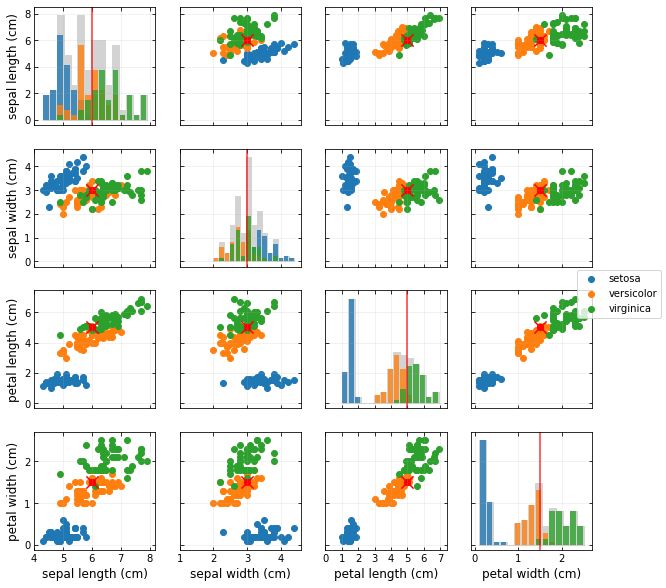

In [8]:
# Code to plot the data and the instance that we want to explain.
x = data.data
y = y_all_pred
y_names = {i:name for i, name in enumerate(data.target_names)}
axis, _ = GridPlot.plot(x=x, x_cols_name=data.feature_names, y=y, y_names=y_names)
GridPlot.plot_instance(x_explain, axis)
for ax in axis.ravel():
    start, end = ax.get_xlim()
    stepsize = 1
    ax.xaxis.set_ticks(np.arange(int(start), end, stepsize))

Form the above figure, we can see that the feature **pental length (cm)** can perfectly separate the class setosa from the other two. Additionally, for values of **pental length (cm)**  between 2.5 and ~5, the predicted class is versicolor, and we would expect that increase the value **pental length (cm)** close to 5 will increase the probability of the ML predict the class virginica. A similar behavior can be observed for the feature **pental width (cm)**.

In [9]:
xgrid = np.linspace(-3.5, 3.5, 40)
ygrid = np.linspace(-6, 6, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

## Lime Standard Explantion

In [10]:
categorical_features = []

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train,
    feature_names=data.feature_names,
    class_names=data.target_names,
    categorical_features=categorical_features,
    verbose=True,
    mode='classification',
    discretize_continuous=False
)

In [12]:
exp = explainer.explain_instance(
    x_explain,
    rf.predict_proba,
    num_features=4)

Intercept 0.5714433209004427
Prediction_local [0.47847139]
Right: 0.6


In [13]:

exp.domain_mapper.feature_values

['6.00', '3.00', '5.00', '1.50']

In [14]:
# Dictionary for plot the explanation
explanation = dict(
    chi_names=exp.domain_mapper.feature_names,
    chi_values=np.array(x_explain).reshape(1,-1),
    x_values=np.array([exp.domain_mapper.feature_values]),
    x_names=exp.domain_mapper.feature_names,
    y_p=rf.predict_proba(x_explain.reshape(1, -1))[0, 1],
    y_p_max=1.0,
    y_p_min=0.0,
    y_p_local_model=exp.local_pred[0],
    y_p_local_model_max=None,
    y_p_local_model_min=None,
    error=None,
    importances=[e[1] for e in exp.as_list()],
    diff_convergence_importances=None,
    ind_class_sorted=0,
    class_names= ["lenght"]
)

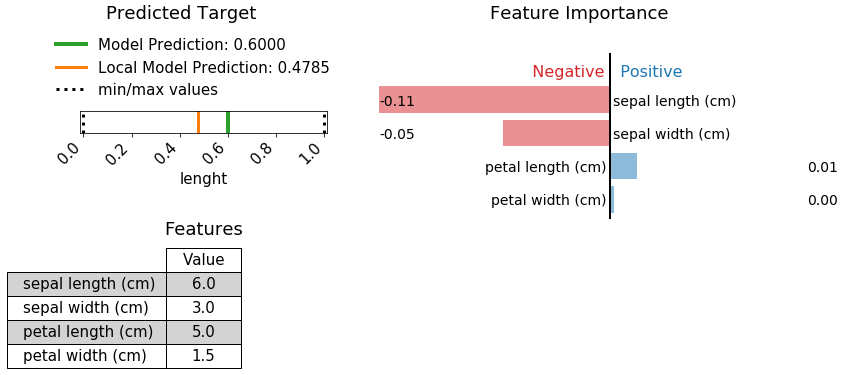

In [15]:
fig, axs = ExplainGraph.plot(explanation)
plt.savefig(f'iris_x_{x_explain}_lime.png', dpi=300)

In [16]:
exp.show_in_notebook(show_table=True)

## M-LIME - KDE - Explantion

In [17]:
generator = KDEGen(verbose=True).fit(x_train)

Best Parameter for the KDE:
{'bandwidth': 0.18736842105263157}
Score: -49.26736470437019


In [18]:
explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=data.feature_names,
    target_names=data.target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.05,
    tol_error=0.05,
    local_mini_batch_max=20,
    scale_data=False,
    weight_kernel='gaussian'
)

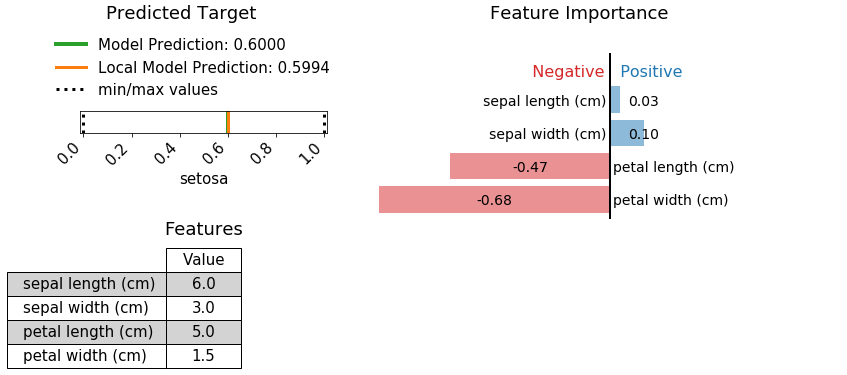

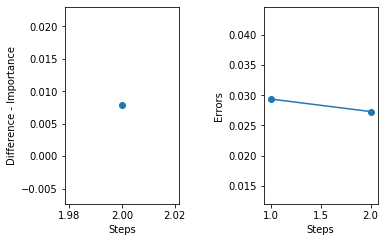

In [19]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'iris_x_{x_explain}_m-lime_kde.png')
fig, axs = ExplainGraph.plot_errors(explanation)

## M-LIME - KDE-PCA - Explantion

In [20]:
generator = KDEPCAGen(n_components=3).fit(x_train)

In [21]:
explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=data.feature_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    class_index=1,
    r=0.5,
    n_samples=500,
    tol_importance=0.05,
    tol_error=0.05,
    local_mini_batch_max=20,
    scale_data=False,
    weight_kernel='gaussian'
)

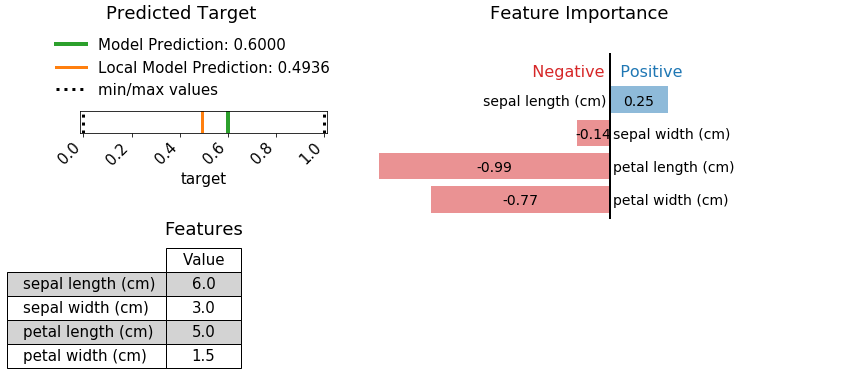

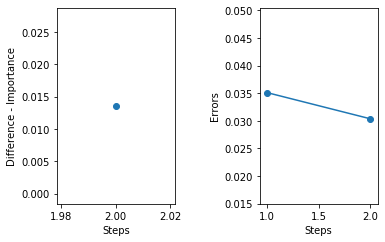

In [22]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'iris_x_{x_explain}_m-lime_pcakde.png')
fig, axs = ExplainGraph.plot_errors(explanation)

Thank you!